In [13]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(export))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lsmeans))

In [2]:
profile <- read.csv(file = "stat_corrected.csv", as.is = TRUE)
profile$Diet <- as.factor(profile$Diet)
profile$MouseID <- ordered(profile$MouseID)
profile$MouseID <- as.factor(profile$MouseID)

In [21]:
mycolor <- c("black", "#0080ff", "#ffa500", "red", "darkgreen")
lines <- c("dashed", "solid", "solid", "solid", "solid")
shapes <- c(1, 24, 4, 15, 25)
theme_set(theme_bw())

In [6]:
Contrasts <- list(
    'TXN vs HFD' = c(0, -1, 0, 0, 1),
    'HXN vs HFD' = c(0, -1, 0, 1, 0),
    'LFD vs HFD' = c(1, -1, 0, 0, 0),
    'TXN vs LFD' = c(-1, 0, 0, 0, 1),
    'LXN vs HFD' = c(0, -1, 1, 0, 0))

Contrasts1 <- list(
    'HFD vs LFD' = c(-1, 1, 0, 0, 0),
    'LXN vs LFD' = c(-1, 0, 1, 1, 0),
    'HXN vs LFD' = c(-1, 0, 0, 1, 0),
    'TXN vs LFD' = c(-1, 0, 0, 0, 1),
    'TXN vs HFD' = c(0, -1, 0, 0, 1))


median_RQ_lt <- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medRQ = median(RQ)) %>% filter(Cycle=="light")
median_RQ_dk<- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medRQ = median(RQ)) %>% filter(Cycle=="dark")

median_EE_lt <- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medEE = median(EE)) %>% filter(Cycle=="light")
median_EE_dk<- profile %>% group_by(MouseID, Diet, Cycle) %>% summarise(medEE = median(EE)) %>% filter(Cycle=="dark")

In [7]:
model_lt <- lm(medEE ~ Diet, data=median_EE_lt)
leastsquare <- lsmeans(model_lt, "Diet")
output <- contrast(leastsquare, Contrasts, adjust = "none")
print(output)

 contrast   estimate     SE df t.ratio p.value
 TXN vs HFD -0.07218 0.0212 54 -3.412  0.0012 
 HXN vs HFD -0.04972 0.0207 54 -2.403  0.0197 
 LFD vs HFD -0.05824 0.0207 54 -2.815  0.0068 
 TXN vs LFD -0.01393 0.0212 54 -0.659  0.5129 
 LXN vs HFD -0.00111 0.0207 54 -0.053  0.9575 



In [8]:
eebox <- profile %>% select(1:5) %>% group_by(Diet, Cycle)

f <- function(x){
  r <- quantile(x, probs = c(0.10, 0.25, 0.5, 0.75, 0.90))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

o <- function(x){
  subset(x, x < quantile(x, probs = 0.1) | quantile(x, probs = 0.9) < x)
}

eeboxp <- ggplot(data=eebox, aes(x=Diet, y=EE, fill=Diet)) +
    stat_summary(fun.data = f, geom = "boxplot", position = "dodge") +
    #stat_summary(fun.y = o, geom = "point") +
    scale_fill_manual(values = alpha(mycolor, .6)) +
    xlab("") + ylab("kcal / hr") +
    facet_grid(~ Cycle) 

eeboxp <- eeboxp + 
    theme(axis.title.y = element_text(size = 20, margin = margin(t=0, r=10, b=0, l=0)),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          legend.title = element_text(size = 15, face = "bold", colour = "#303F9F"),
          legend.text = element_text(size = 16),
          legend.position = "none",
          strip.text = element_text(size = 15, face = "bold"),
          plot.margin = unit(c(0.5,0.5,0.5,0.5), "cm"))

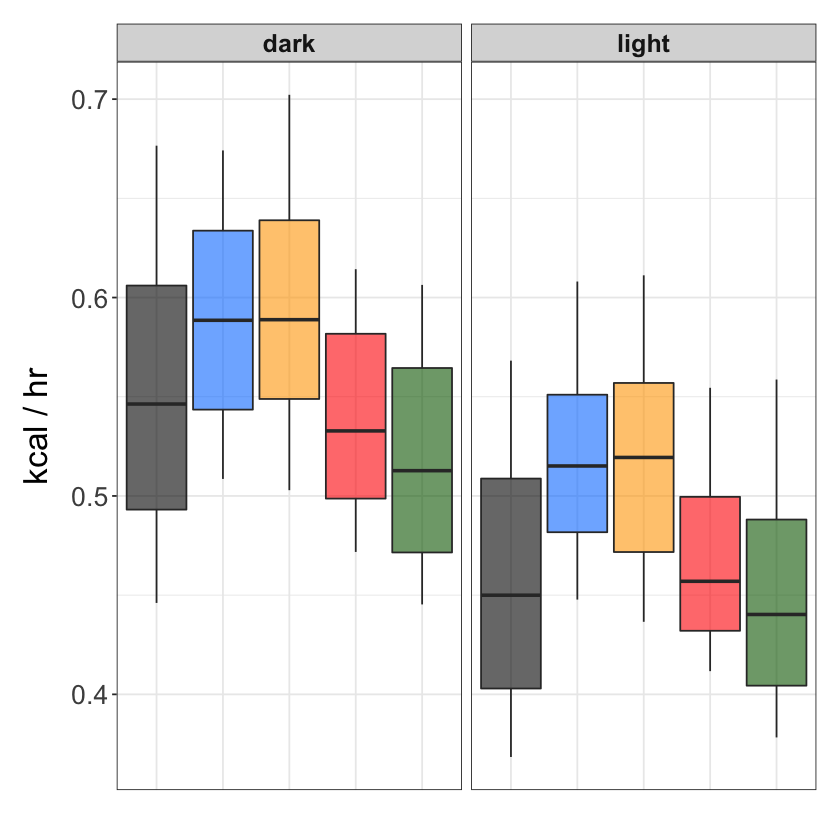

In [9]:
eeboxp

In [18]:
EE <- ggline(profile, x = "Time", y = "EE", group = "Diet",
       add = "mean_se", color = "Diet", palette = mycolor,
       ylab = "kcal/hr", xlab = "", 
       linetype = "Diet", shape = "Diet",
       point.size = 1.5,
       ggtheme = theme_bw())


EE <- EE + 
    annotate("rect", xmin="Cycle1:17:00-18:00", xmax="Cycle1:05:00-06:00", ymin=0.3, ymax=0.78, 
             alpha=0.2, fill="#303F9F") +
    annotate("rect", xmin="Cycle2:17:00-18:00", xmax="Cycle2:05:00-06:00", ymin=0.3, ymax=0.78, 
             alpha=0.2, fill="#303F9F")


EE <- EE + scale_linetype_manual(values=c("dashed", "solid", "solid", "solid", "solid")) +  
    scale_shape_manual(values = shapes) +
    theme(axis.title.y = element_text(size = 20, margin = margin(t=0, r=10, b=0, l=10)),
          axis.text.y = element_text(size = 16),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          legend.title = element_text(size = 15, face = "bold", colour = "white"),
          legend.text = element_text(size = 18),
          legend.position = "bottom",
          plot.margin = unit(c(0.5,0.5,0,0.5), "cm"))

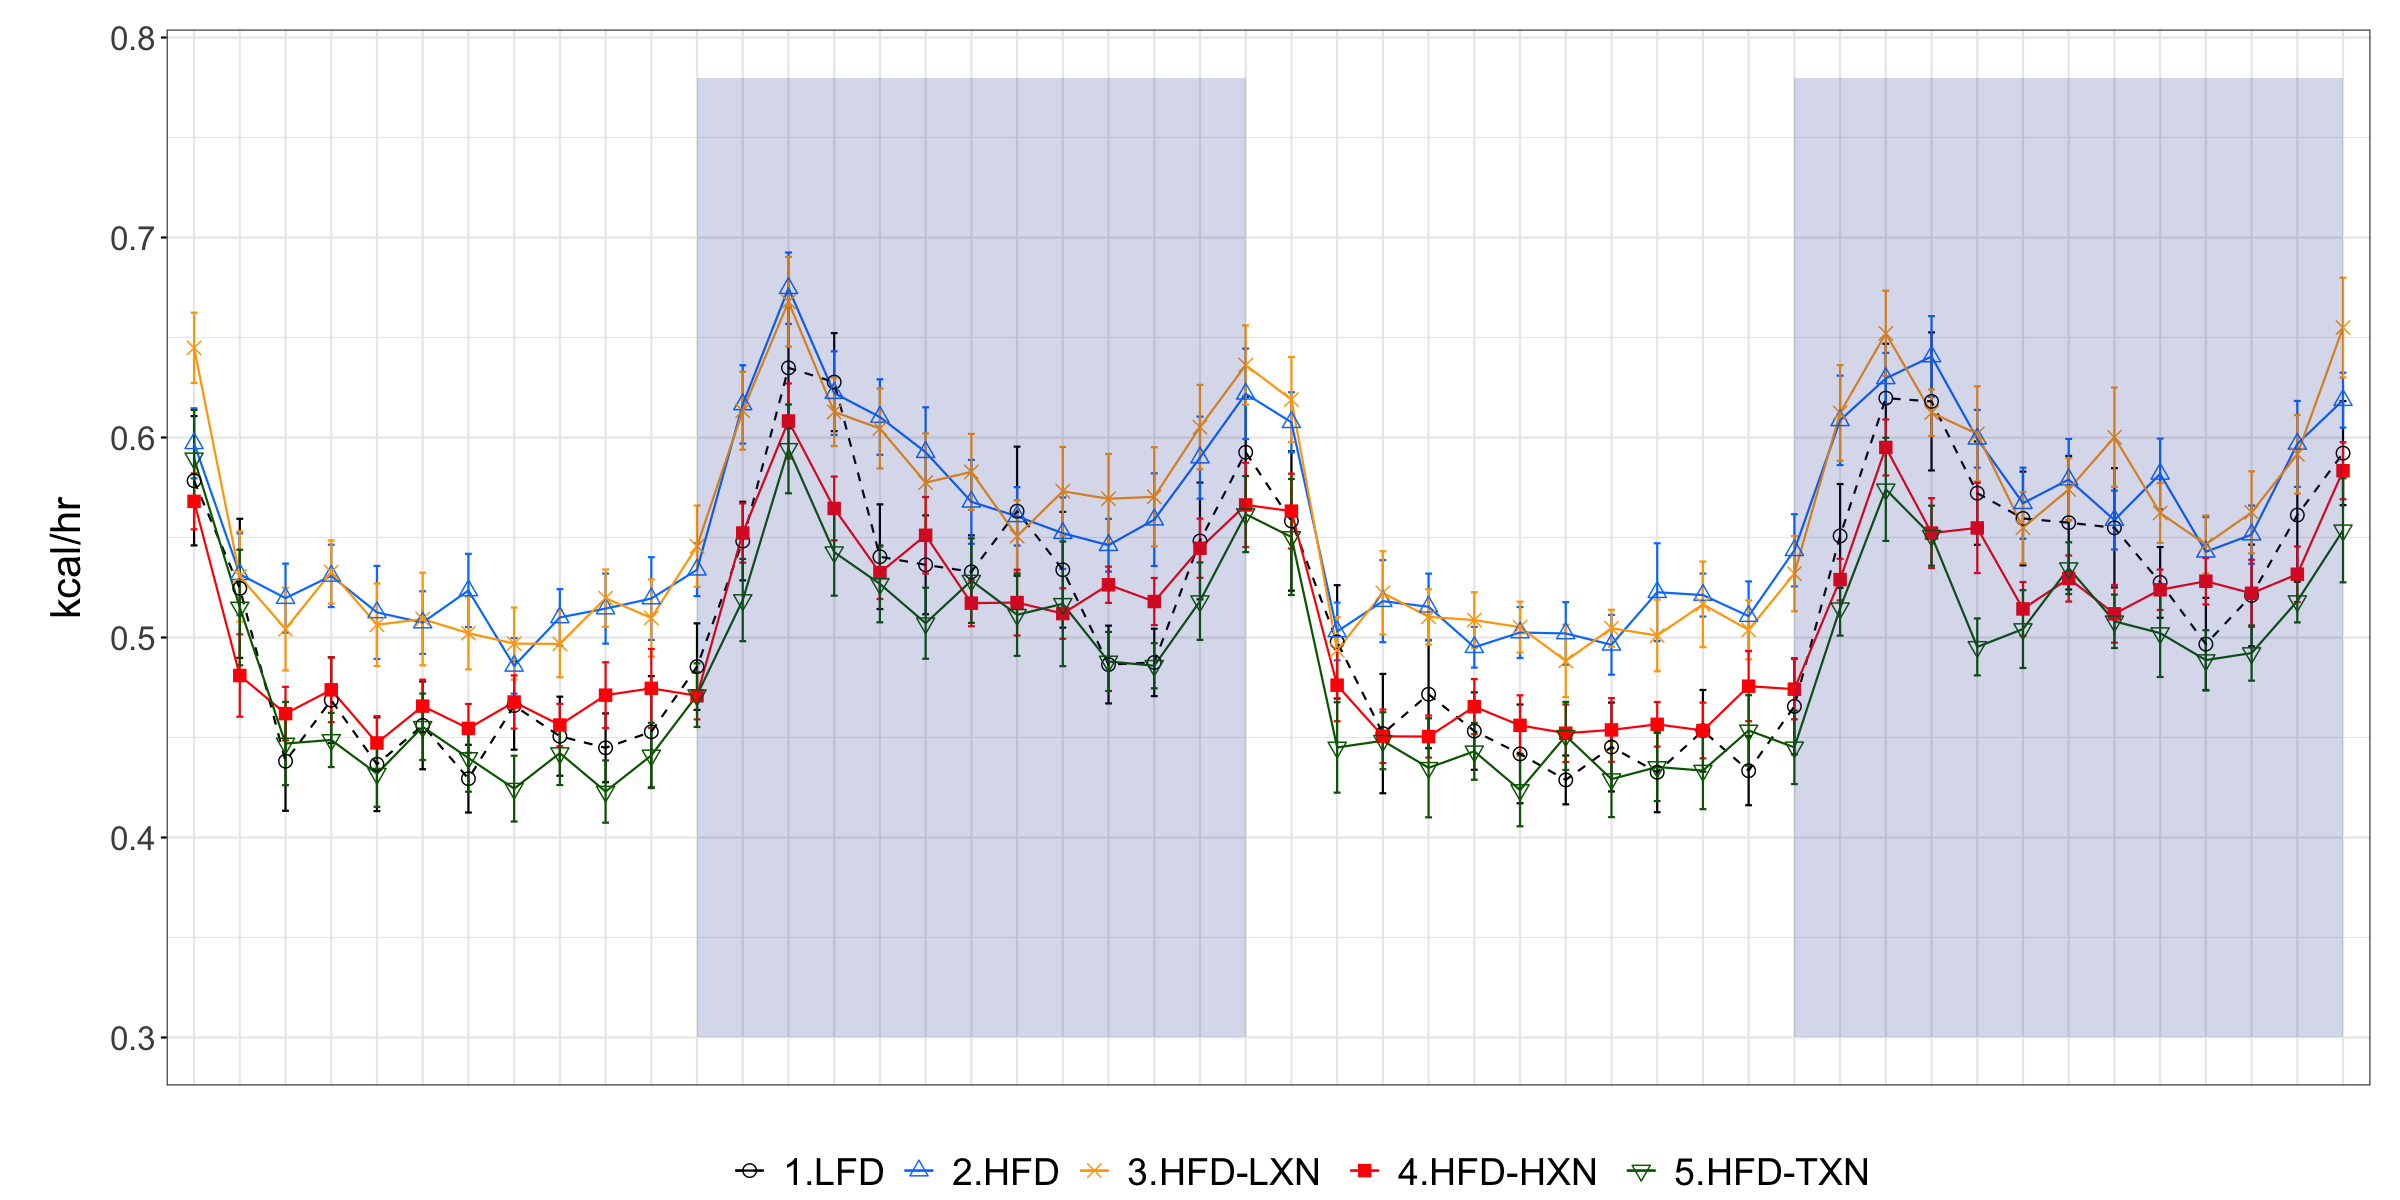

In [19]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 150)
EE

In [22]:
#graph2pdf(EE, "EE.pdf", width = 16, height = 8)

In [31]:
data <- read.csv("table3.csv", header = T); 
data$vars <- factor(data$Treatment, levels = c("LFD", "HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN"))
data$vars2 <- factor(data$Treatment, levels = c("HFD", "HFD+LXN", "HFD+HXN", "HFD+TXN", "LFD"))
data <- data %>% mutate(lv_tot_tag = LV_TAG * liver_wt,
                        EE_norm = avgEE*1000/Lean_mass, 
                        fecal_tot_tag = TG_feces*fecal_tot_output, 
                          rest_fat = Fat_mass - lv_tot_tag/1000 - (TG_feces*fecal_tot_output)/1000 - plasma_TAG*58.5*(wt/1000)/(100*1000)); head(data)

,ID,Treatment,Cal_cum,LV_TAG,lipidosis_area_pct,Fat_mass,subq_wt,epi_wat,mesenteric_wt,plasma_TAG,⋯,fecal_tot_output,wt,Lean_mass,avgEE,vars,vars2,lv_tot_tag,EE_norm,fecal_tot_tag,rest_fat
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,LFD,1425.870,367.77,17.596,11.152,0.40,1.80,0.33,38.547,⋯,0.75,38.4,21.978,0.4882563,LFD,LFD,581.0766,22.21568,17.55000,10.552507
2,2,LFD,1241.231,400.53,0.696,7.357,0.72,1.34,0.48,53.408,⋯,0.72,33.1,20.333,0.4432477,LFD,LFD,512.6784,21.79943,15.02280,6.828265
3,3,LFD,1298.180,379.47,17.311,10.517,0.89,2.08,0.94,68.087,⋯,0.66,35.7,19.183,0.5524005,LFD,LFD,523.6686,28.79635,13.38480,9.978525
4,4,LFD,1812.026,332.67,16.353,12.781,0.78,2.13,0.54,37.492,⋯,0.90,43.0,22.879,0.6890067,LFD,LFD,652.0332,30.11525,20.70900,12.107315
5,5,LFD,1373.638,408.33,5.164,6.385,0.26,0.97,0.32,46.053,⋯,0.89,32.2,21.055,0.4737070,LFD,LFD,563.4954,22.49855,17.52855,5.803109
6,6,LFD,1448.174,454.35,22.362,11.460,0.99,2.07,0.60,45.932,⋯,0.76,39.5,21.940,0.5563389,LFD,LFD,722.4165,25.35729,7.85460,10.728668


In [27]:
.ci <-
function(x,conf.level=0.95) {
  tri <- sort(na.omit(x))
  if (any(!is.finite(tri))) {tri <- tri[-which(!is.finite(tri))]}
  repet <- length(tri)
  int <- (1-conf.level)/2
  if(repet*int<1) {
    int.inf <- ceiling(repet*int)
  } else {
    int.inf <- floor(repet*int)
  }
  int.sup <- ceiling(repet*(1-int))
  result <- c("Inf"=tri[int.inf],"Sup"=tri[int.sup])
  return(result)
}

spearman.ci <-
function(var1,var2,nrep=1000,conf.level=0.95){
  if (length(var1)!=length(var2)) {stop(paste("'",deparse(substitute(var1)),"' and '",
    deparse(substitute(var2)),"' lengths differ",sep=""))}
  data.name <- paste(deparse(substitute(var1))," and ",deparse(substitute(var2)),"\n",nrep," replicates",sep="")
  nul <- as.numeric(row.names(table(c(which(is.na(var1)),which(is.na(var2))))))
  var1.2 <- if(length(nul)>0) {var1[-nul]} else {var1}
  var2.2 <- if(length(nul)>0) {var2[-nul]} else {var2}
  cor.fun <- function(data,ind) {
    as.numeric(suppressWarnings(cor.test(data[ind,1],data[ind,2],method="spearman")$estimate))
  }
  simul <- boot::boot(data.frame(var1.2,var2.2),cor.fun,R=nrep)
  interval <- .ci(simul$t,conf.level=conf.level)
  attr(interval,"conf.level") <- conf.level
  coeff <- as.numeric(suppressWarnings(cor.test(var1,var2,method="spearman")$estimate))
  names(coeff) <- "rho"
  result <- list(method="Spearman's rank correlation",conf.level=conf.level,rep=nrep,data.name=data.name,
    estimate=coeff,conf.int=interval)
  class(result) <- "htest"
  return(result)
}

In [28]:
data %>%
    summarise(r = spearman.ci(avgEE, Lean_mass)$estimate,
             pvalue = cor.test(avgEE, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(avgEE, Lean_mass)$conf.int[1],
             upper = spearman.ci(avgEE, Lean_mass)$conf.int[2])

r,pvalue,lower,upper
<dbl>,<dbl>,<dbl>,<dbl>
0.728346,0,0.5921592,0.8138596


In [29]:
data %>%
    group_by(vars) %>%
    summarise(r = spearman.ci(avgEE, Lean_mass)$estimate,
             pvalue = cor.test(avgEE, Lean_mass, method = "spearman")$p.value,
             lower = spearman.ci(avgEE, Lean_mass)$conf.int[1],
             upper = spearman.ci(avgEE, Lean_mass)$conf.int[2])

vars,r,pvalue,lower,upper
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
LFD,0.6083916,0.04000205,-0.05673759,0.9784173
HFD,0.4195804,0.17657701,-0.19708029,0.8455882
HFD+LXN,0.5734266,0.05548132,0.05714286,0.8652482
HFD+HXN,0.4615385,0.13383632,-0.20284698,0.8260870
HFD+TXN,0.6909091,0.02305887,0.03349282,0.9903846


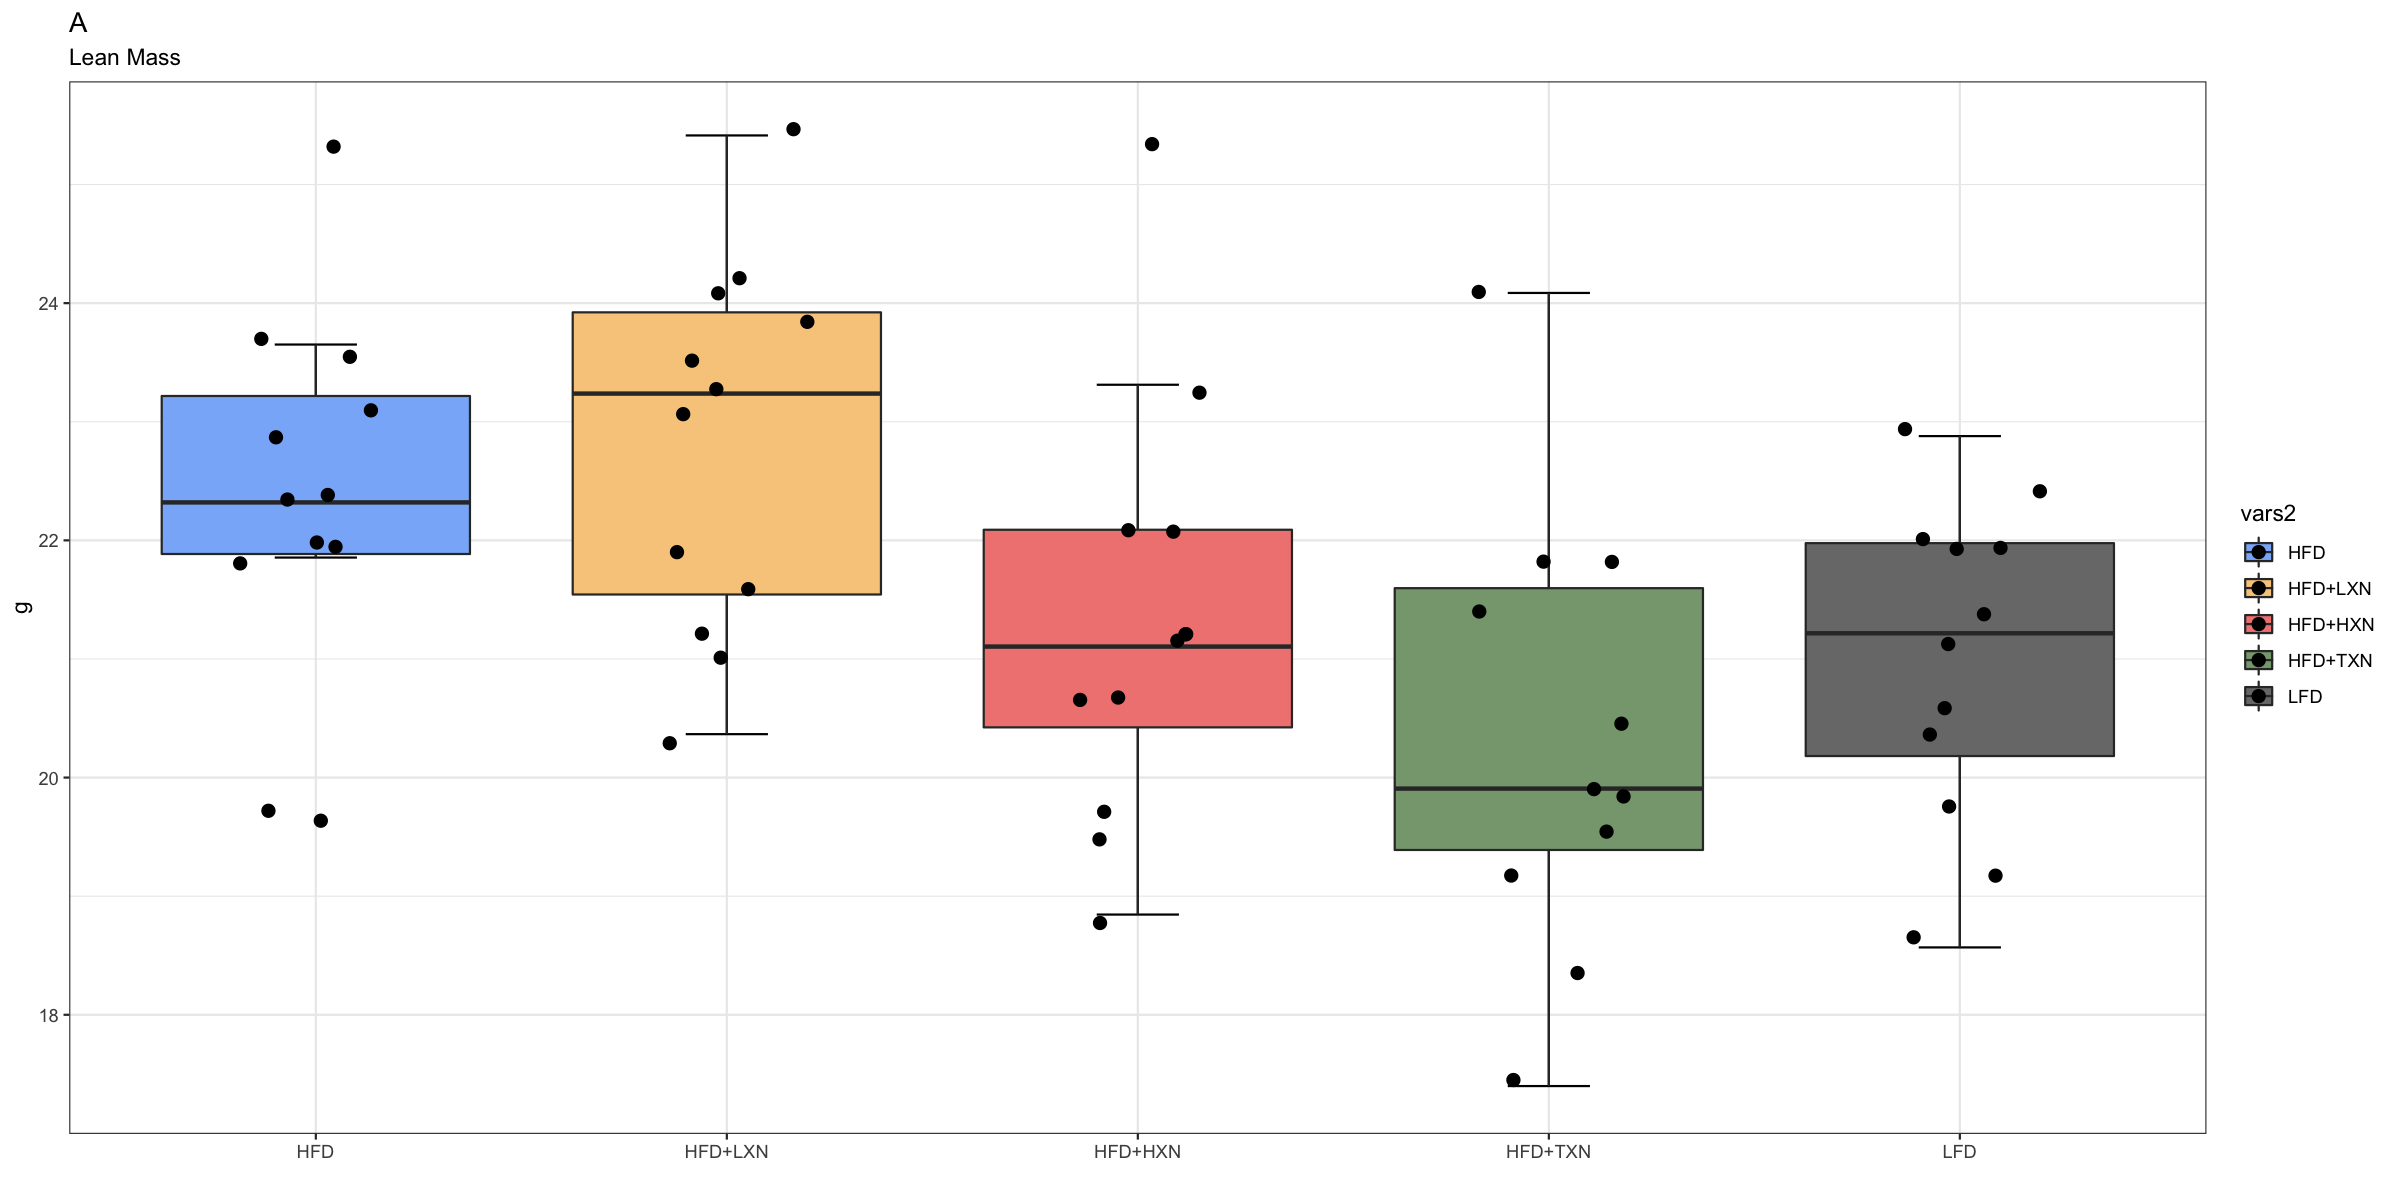

In [30]:
mycolor_alpha <- c("#8AB5F9", "#F8CB89", "#F08581", "#87A57E", "#797979")
ggplot(data = data, aes(x = vars2, y = Lean_mass, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 4, width = 0.2, height = 0.1) +
    labs(x = '', y = 'g', subtitle = "Lean Mass") +
	#xlab(" ") + ylab("mg") +
	ggtitle("A") +
	theme_bw() 

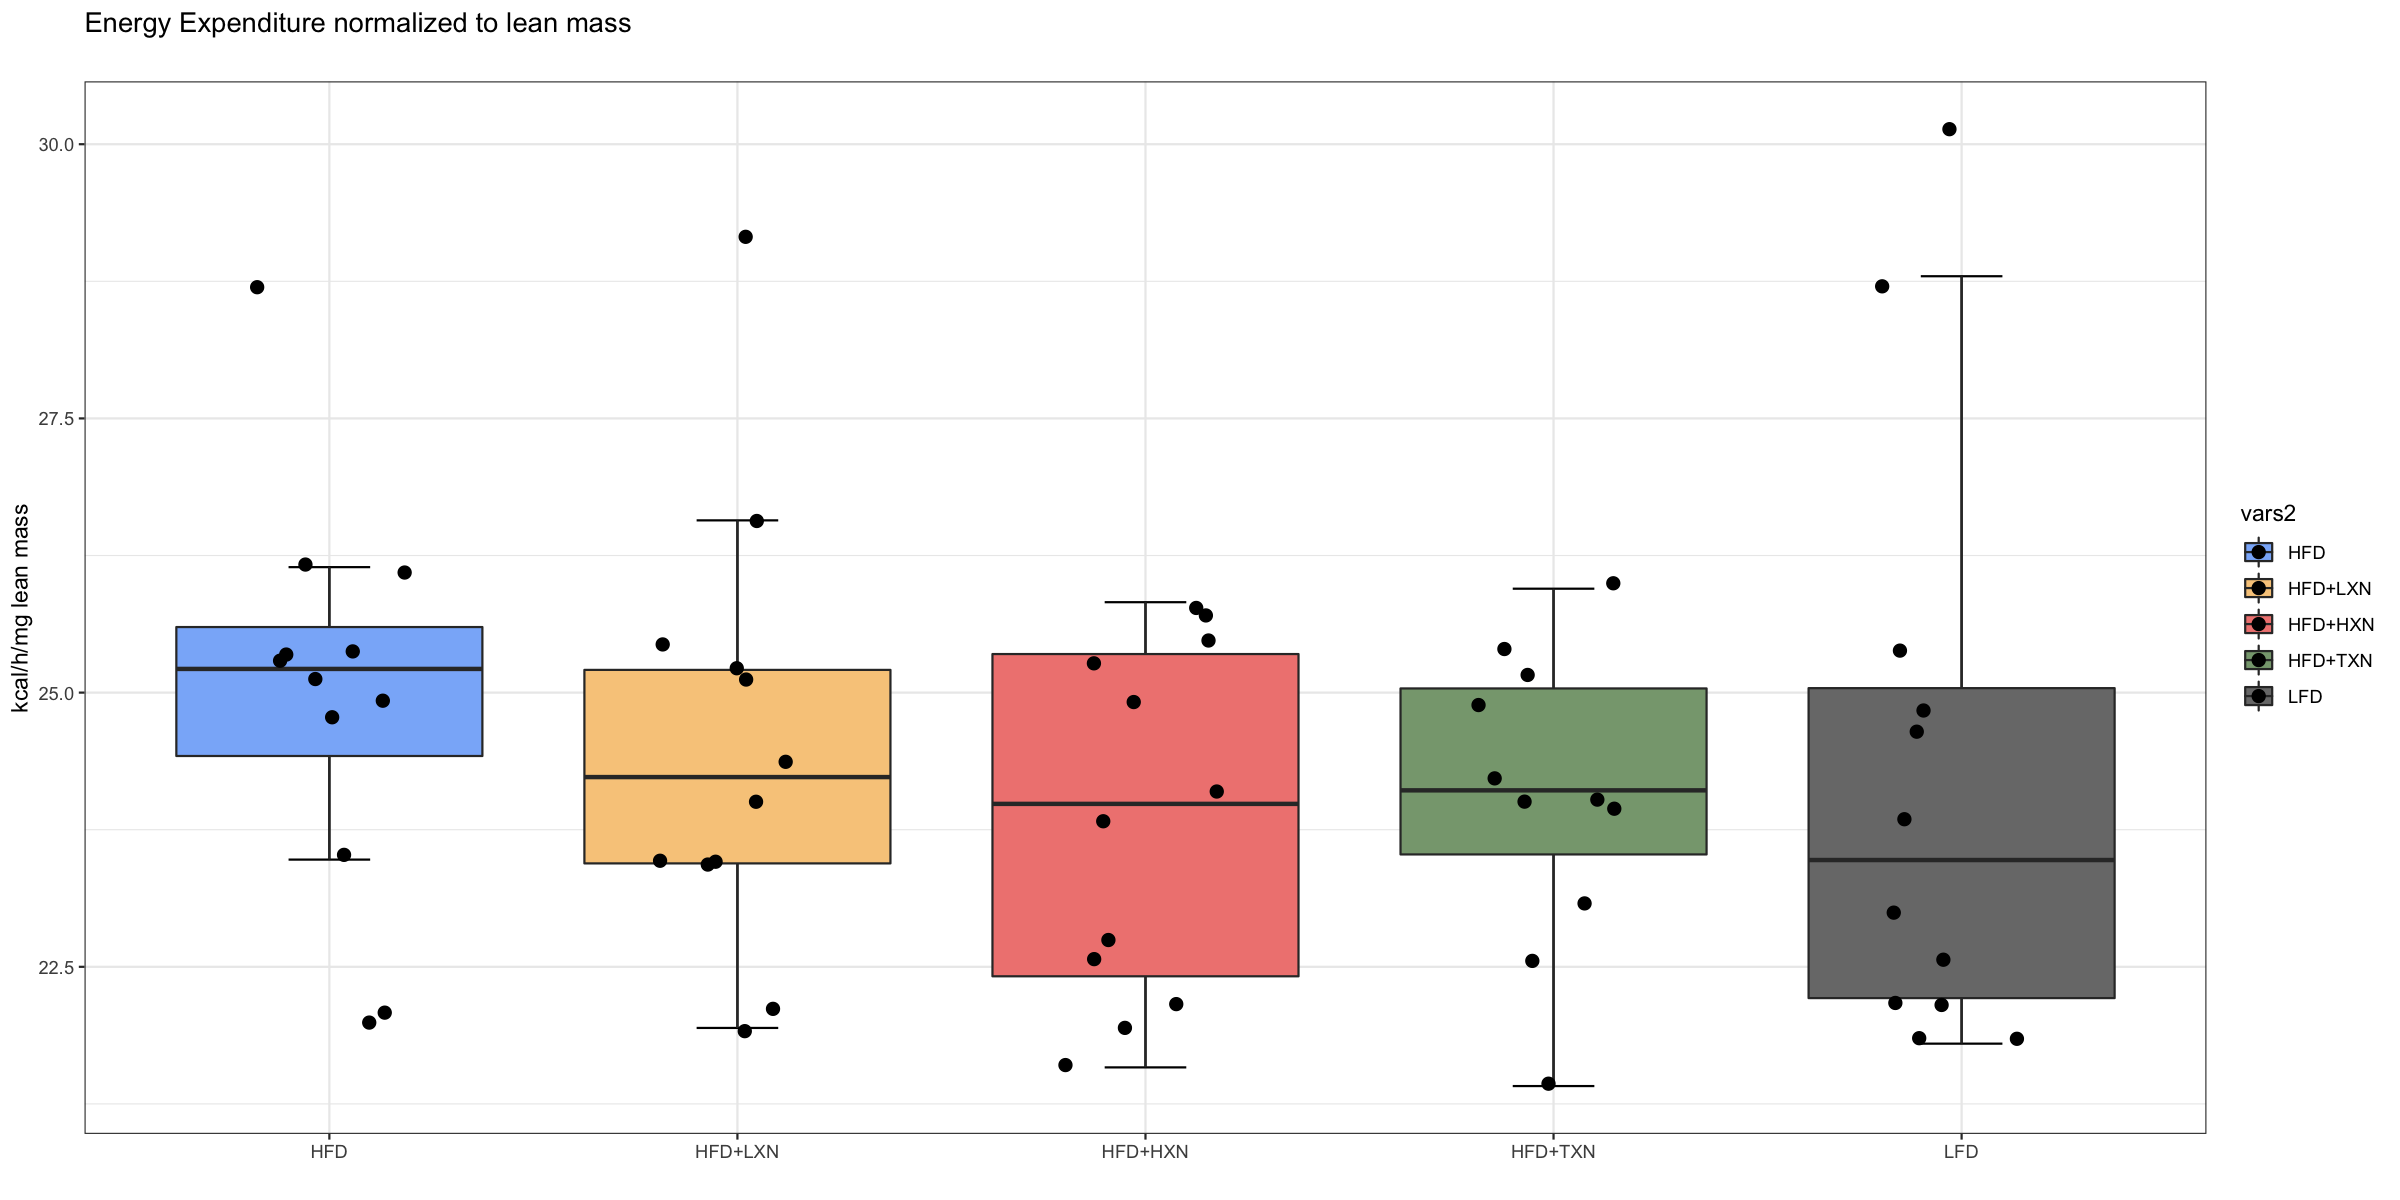

In [33]:
ggplot(data = data, aes(x = vars2, y = EE_norm, fill = vars2)) +
	stat_boxplot(geom = 'errorbar', linetype = 1, width = 0.2) +
	geom_boxplot(outlier.shape = NA) +
	scale_fill_manual(values = mycolor_alpha) +
	geom_jitter(shape = 20, size = 4, width = 0.2, height = 0.1) +
    labs(x = '', y = 'kcal/h/mg lean mass', subtitle = "") +
	#xlab(" ") + ylab("mg") +
	ggtitle("Energy Expenditure normalized to lean mass") +
	theme_bw() 